In [28]:

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import matplotlib.patches as mpatches


In [4]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.io import loadmat
from scipy.special import gamma
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.patches as patches
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
def embedding_fit_metrics(original_distances, embedded_distances):
    """
    Computes the following goodness-of-fit metrics for an embedding:
    1. Spearman's Rank Correlation
    2. Pearson Correlation
    3. R^2 value (MSE to the line y = x)

    Parameters:
    original_distances (array-like): Pairwise distances in the original space.
    embedded_distances (array-like): Pairwise distances in the embedded space.

    Returns:
    dict: A dictionary containing Spearman's rho, Pearson's r, and R^2 value.
    """
    
    # Ensure input is NumPy arrays
    original_distances = np.array(original_distances)
    embedded_distances = np.array(embedded_distances)
    
    # Compute Spearman's rank correlation
    spearman_corr, _ = spearmanr(original_distances, embedded_distances)
    
    # Compute Pearson correlation
    pearson_corr, _ = pearsonr(original_distances, embedded_distances)
    
    # Compute R^2 value (MSE to the line y = x)
    r2 = r2_score(original_distances, embedded_distances)
    
    return {
        "Spearman Rank Correlation": spearman_corr,
        "Pearson Correlation": pearson_corr,
        "R^2 Value": r2
    }
def vol(R, D):
    c = 2*np.power(np.pi, 0.5*D)
    itg = integrate.quad(lambda x: np.power(np.sinh(x), D-1), 0.0, R)[0]
    return c*itg

def sample_r(R, D):
    rmin = 0.0; rmax = R; rc = 0.5*R
    V_tot = vol(R, D); uc = vol(rc, D)/V_tot
    u = np.random.uniform()
    while(np.abs(u-uc)>1e-4):
        if uc < u:
            rmin = rc
            rc = 0.5*(rc + rmax)
            uc = vol(rc, D)/V_tot
        elif u < uc:
            rmax = rc
            rc = 0.5*(rc + rmin)
            uc = vol(rc, D)/V_tot
    return rc

#uniformly sample a point in hyperbolic space out to Rmax
#return point in poincare coords
def h_samp(rm, D):
    direction = np.random.normal(size=D)
    direction = direction/np.sqrt(np.sum(np.square(direction)))
    #th = 2.0*np.pi*np.random.uniform()
    r_p = sample_r(rm, 2)
    return np.tanh(r_p/2.0)*direction
    #return np.tanh(r_p/2.0)*np.asarray([np.cos(th), np.sin(th)])

def pdist(p1, p2):
    inv = 2.0*(p1-p2).dot(p1-p2)/((1-p1.dot(p1))*(1-p2.dot(p2)))
    return np.arccosh(1.0 + inv)
class HMDS():
    def __init__(self, deltaij, D, a=2, b=0.5, sig_lam=10, tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_lam = tf.Variable(0, dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_lam = sig_lam

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []
        self.lambda_curve = []
        
    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(tf.divide(dist,tf.math.exp(self.log_lam)) - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_lam = tf.scalar_mul(tf.divide(tf.cast(self.N*(self.N-1),tf.float32),4*(self.sig_lam**2)),tf.math.exp(self.log_lam)**2)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_lam + prior_sig + tf.reduce_sum(self.log_sig) + self.log_lam

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_lam])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_lam]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            self.lambda_curve.append(np.exp(self.log_lam.numpy()))
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_lambda(self):
        plt.figure()
        plt.plot(self.lambda_curve)
        plt.xlabel('Step')
        plt.ylabel('Lambda')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        plt.figure()
        plt.scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)]/np.exp(self.log_lam))
        plt.xlabel('True Distance')
        plt.ylabel('Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords

    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())
        lam = np.exp(self.log_lam.numpy())
        emb_mat = self.pairwise_dist_lorentz().numpy()
        
        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi)
        return lkl[0]

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())
class nonmetricHMDS():
    def __init__(self, deltaij, D, Ns, a=2, b=0.5, sig_lam=10, sig_w=1, sig_b=10, sig_s=10,  tolerance=1e-10):
        ## Parameters ##
        self.deltaij = tf.constant(deltaij, dtype=tf.float32)
        self.N = tf.constant(deltaij.shape[0])
        self.D = tf.constant(D)
        self.Ns = tf.constant(Ns)

        ## Variables ##
        self.euc = tf.Variable(tf.random.normal(shape=(self.N, self.D), mean=0.0, stddev=.0001), dtype=tf.float32)
        self.log_sig =tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), dtype=tf.float32)
        self.log_w = tf.Variable(np.log(np.ones(self.Ns)/Ns), dtype=tf.float32)
        self.log_b = tf.Variable(tf.random.normal([self.Ns], mean=0, stddev=0.001), dtype=tf.float32)
        self.log_s = tf.Variable(np.log(np.linspace(1/self.Ns,1+1/self.Ns,self.Ns)), dtype=tf.float32)

        ## Constraints ##
        self.time = tf.Variable(tf.random.normal(shape=(self.N,1), mean=0, stddev=0.001), shape=(self.N,1), trainable=False)

        ## Model Hyperparameters ##
        self.a = a
        self.b = b
        self.sig_w = sig_w
        self.sig_b = sig_b
        self.sig_s = sig_s

        ## Optimization Hyperparameters ##
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.tolerance = tolerance

        ## Optimization Results ##
        self.loss_curve = []

    @tf.function
    def constraint_time(self):
        return tf.expand_dims(tf.sqrt(tf.add(1.0,tf.square(tf.norm(self.euc,axis=1)))),1)

    @tf.function
    def pairwise_dist_lorentz(self):
        self.time = self.constraint_time()
        time_product = tf.matmul(self.time, self.time, transpose_b=True)
        space_product = tf.matmul(self.euc, self.euc, transpose_b=True)
        lorentzian_inner_product = time_product - space_product
        lorentzian_inner_product_clipped = tf.maximum(lorentzian_inner_product, 1.0+1e-7)
        distance_matrix = tf.math.acosh(lorentzian_inner_product_clipped) + 1e-12
        return distance_matrix

    @tf.function
    def sigmoid(self,x):
        return tf.math.sigmoid(4*x)

    @tf.function
    def monotonic(self,x):
        dist_s = tf.expand_dims(x, axis=-1) - tf.math.exp(tf.expand_dims(self.log_s, axis=0))
        dist_bs = tf.multiply(dist_s,tf.math.exp(tf.expand_dims(self.log_b, axis=0)))
        sig = self.sigmoid(dist_bs)
        transformed_dist = tf.multiply(sig,tf.math.exp(tf.expand_dims(self.log_w, axis=0)))
        return tf.reduce_sum(transformed_dist, axis=-1)
        
    @tf.function
    def loss(self):
        dist = self.pairwise_dist_lorentz()
        trans_dist =  self.monotonic(dist)
        s2 = tf.transpose(tf.square(tf.math.exp(self.log_sig))) + tf.square(tf.math.exp(self.log_sig)) + 1e-12
        stress = tf.divide(tf.square(trans_dist - self.deltaij),s2)
        lkl = tf.add(stress, tf.math.log(tf.scalar_mul(2*np.pi, s2)))
        mask = tf.cast(tf.linalg.band_part(tf.ones_like(lkl),0, -1) - tf.eye(tf.shape(lkl)[0]), dtype=tf.bool)
        lkl_upper = tf.boolean_mask(lkl,mask)
        prior_sig = tf.reduce_sum(tf.scalar_mul((self.a + 1), self.log_sig) + tf.divide(self.b, tf.math.exp(self.log_sig)))
        return 0.5*tf.reduce_sum(lkl_upper) + prior_sig + tf.reduce_sum(self.log_sig) + tf.reduce_sum(self.log_w) + tf.reduce_sum(self.log_b) + tf.reduce_sum(self.log_s)# + self.log_lam + prior_lam + 

    @tf.function
    def train_step(self):
        with tf.GradientTape() as tape:
            loss_value = self.loss()
        grads = tape.gradient(loss_value, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s])
        self.optimizer.apply_gradients(zip(grads, [self.euc, self.log_sig, self.log_w, self.log_b, self.log_s]))
        gradient_norm = tf.reduce_sum([tf.reduce_sum(tf.square(g)) for g in grads])
        return loss_value, gradient_norm

    def train(self, n=50000):
        #self.plot_transformation()
        for epoch in range(n):
            loss_val, gradient_norm = self.train_step()
            self.loss_curve.append(loss_val)
            if epoch % 5000 == 0:
                print(f'epoch {epoch}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}')
            if gradient_norm < self.tolerance:
                print(f"Converged at epoch {epoch + 1}, Loss: {loss_val.numpy()}, normG: {gradient_norm.numpy()}")
                break  # Stop training

    ## Visualization ##
    def plot_loss(self):
        plt.figure()
        plt.plot(self.loss_curve)
        plt.xlabel('Step')
        plt.ylabel('-Log Likelihood')
        plt.show()

    def plot_transformation(self):
        plt.figure()
        maxDist = np.max(self.pairwise_dist_lorentz().numpy())
        x = np.linspace(0-5,maxDist+10,100,dtype=np.float32)
        plt.plot(x,self.monotonic(x))
        plt.vlines(maxDist,0,self.monotonic(maxDist),linestyles='dashed',color='red')
        plt.xlabel('Input Distance')
        plt.ylabel('Output Distance')
        plt.show()

    def plot_sigmas(self):
        plt.figure()
        plt.hist(np.exp(self.log_sig.numpy()))
        plt.xlabel('Sigma')
        plt.ylabel('Counts')
        plt.show()

    def shepard(self):
        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        ax[0].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.pairwise_dist_lorentz().numpy()[np.triu_indices(self.N,k=1)])
        ax[0].set_xlabel('True Distance')
        ax[0].set_ylabel('Embedding Distance')
        ax[1].scatter(self.deltaij.numpy()[np.triu_indices(self.N,k=1)], self.monotonic(self.pairwise_dist_lorentz()).numpy()[np.triu_indices(self.N,k=1)])
        ax[1].plot([0,1],[0,1],linestyle='--')
        ax[1].set_xlabel('True Distance')
        ax[1].set_ylabel('Transformed Embedding Distance')
        plt.show()

    def get_poin(self):
        ts = np.sqrt(1.0 + np.sum(np.square(self.euc.numpy()), axis=1))
        p_coords = (self.euc.numpy().T / (ts + 1)).T
        return p_coords
    
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()                             # Original dissimilarities δᵢⱼ
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())                     # σᵢ values
        emb_mat = self.pairwise_dist_lorentz().numpy()          # Raw hyperbolic distances
        transformed = self.monotonic(emb_mat).numpy()           # f(dᵢⱼ)

        for i in np.arange(N):
            for j in np.arange(i+1, N):
                seff = sigs[i]**2 + sigs[j]**2 + 1e-12           # σᵢ² + σⱼ²
                diff = dmat[i][j] - transformed[i][j]            # δᵢⱼ - f(dᵢⱼ)
                lkl += (diff**2 / (2.0 * seff)) + 0.5 * np.log(seff * 2.0 * np.pi)

        return lkl

    def BIC(self):
        N = self.N.numpy()
        D = self.D.numpy()
        Ns = self.Ns.numpy()
        n = 0.5 * N * (N - 1)                         # Number of pairwise observations

        # Number of parameters:
        # - N * D       : embedding coordinates
        # - N           : uncertainty values (log_sig)
        # - 3 * Ns      : parameters for f(x): log_w, log_b, log_s
        k = N * D + N + 3 * Ns

        # Negative log-likelihood using monotonic f(x)
        lkl = self.MDS_lkl()

        # Bayesian Information Criterion
        BIC = k * np.log(n) + 2 * lkl
        return float(BIC)


'''
    ## Metrics ##
    def MDS_lkl(self):
        lkl = 0
        dmat = self.deltaij.numpy()               # Original dissimilarities
        N = self.N.numpy()
        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)
        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)
        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances
        
        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix
            for j in np.arange(i+1, N):     
                seff = sigs[i]**2 + sigs[j]**2
                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?
        return lkl[0] # isn't lkl a scalar? it should return just lkl

    def BIC(self):
        N, D = self.N.numpy(), self.D.numpy()
        n = 0.5*N*(N-1)
        k = N*D + N + 1.0 - 0.5*D*(D-1)
        return float(k*np.log(n) + 2.0*self.MDS_lkl())
'''



"\n    ## Metrics ##\n    def MDS_lkl(self):\n        lkl = 0\n        dmat = self.deltaij.numpy()               # Original dissimilarities\n        N = self.N.numpy()\n        sigs = np.exp(self.log_sig.numpy())       # Uncertainty per point (σᵢ)\n        lam = np.exp(self.log_lam.numpy())        # Curvature scale (λ)\n        emb_mat = self.pairwise_dist_lorentz().numpy()   # Hyperbolic distances\n        \n        for i in np.arange(N):      # Loop Over Upper Triangle of Distance Matrix\n            for j in np.arange(i+1, N):     \n                seff = sigs[i]**2 + sigs[j]**2\n                lkl += ((dmat[i][j] - emb_mat[i][j]/lam)**2 / (2.0*seff)) + 0.5*np.log(seff*2.0*np.pi) # This is the negative log-likelihood for a normal distribution,,, so we are assuming delta_ij belongs to normal dist which is a metric assumption?\n        return lkl[0] # isn't lkl a scalar? it should return just lkl\n\n    def BIC(self):\n        N, D = self.N.numpy(), self.D.numpy()\n        n = 0.5*N*

11490434/11490434 [==============================] - 3s 0us/step


Distance matrix shape: (2000, 2000)  |  max d = 2.379

Fitting Hyperbolic MDS...


2025-05-06 19:31:40.922120: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


epoch 0, Loss: 3793186.75, normG: 556266496.0
epoch 5000, Loss: 2219702.5, normG: 42355290112.0
epoch 10000, Loss: 1902373.25, normG: 241923072.0
epoch 15000, Loss: 1685095.125, normG: 82395896.0


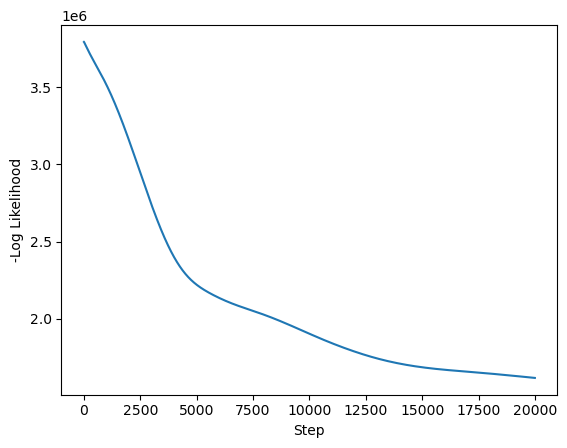

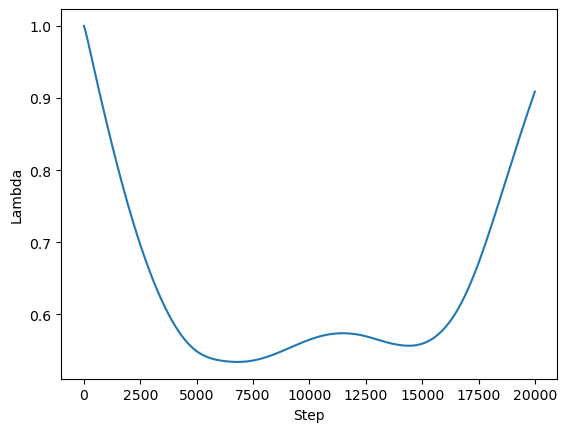

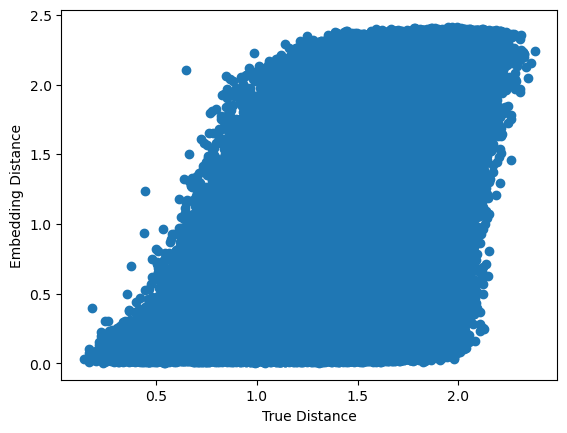


Running Euclidean MDS baseline (scikit‑learn)...


/var/folders/d3/k34hg6v522x_qvcr7lwxt2yc0000gn/T/ipykernel_38191/3270674805.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


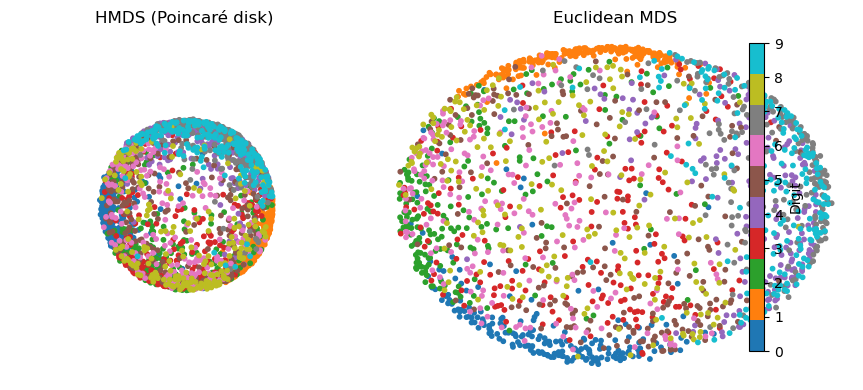


=== Goodness‑of‑fit ===
HMDS  |  R² = -5.2453  |  MSE = 0.3070
EucMDS|  R² = -5.5895  |  MSE = 0.3239


In [2]:
# ---------------------------------------------------------
# MNIST Cosine-Distance Sanity Check for (Non‑)Metric HMDS
# ---------------------------------------------------------
#
# Pipeline implemented here:
#   1. Load MNIST digits (70 000 images)
#   2. Sub‑sample an equal number of examples per digit so the
#      pair‑wise distance matrix fits easily in memory
#   3. (Optional) Reduce dimensionality with PCA to de‑noise
#   4. Compute cosine similarity, then convert to **angular
#      distance**  d_ij = arccos(⟨x_i,x_j⟩)
#   5. Fit the HMDS model with learnable curvature λ
#      — this should drive λ → 0 on MNIST (flat geometry)
#   6. Plot diagnostics: λ‑trajectory, loss curve, Shepard plot
#   7. Compare with Euclidean classical MDS as a baseline
#
# The code is wrapped into a convenience function so it can be
# called with different hyper‑parameters.
# ---------------------------------------------------------


def mnist_cosine_sanity(
    samples_per_digit: int = 200,
    pca_components: int | None = 50,
    embed_dim: int = 2,
    hmds_steps: int = 20_000,
    seed: int = 42,
):
    """Run the sanity‑check experiment described in the chat.

    Parameters
    ----------
    samples_per_digit : int
        Number of MNIST images to draw *per* digit (0‑9).
        Distance matrix size will be (10×samples_per_digit)².
    pca_components : int | None
        If not None, project the flattened pixel vectors onto the
        top *pca_components* principal components before computing
        cosine distances.  Setting to None disables PCA.
    embed_dim : int
        Hyperbolic (or Euclidean) embedding dimension D.
    hmds_steps : int
        Gradient‑descent iterations for the HMDS optimiser.
    seed : int
        RNG seed for reproducibility.
    """

    # 1 ─────────────────────────────────────────────────────
    rng = np.random.default_rng(seed)
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_full = np.concatenate([x_train, x_test], axis=0)
    y_full = np.concatenate([y_train, y_test], axis=0)

    # 2 ── balanced sub‑sample (stratified by digit) ───────
    idx = np.hstack(
        [rng.choice(np.where(y_full == d)[0], samples_per_digit, replace=False)
         for d in range(10)]
    )
    X = X_full[idx].reshape(len(idx), -1).astype(np.float32) / 255.0  # (N, 784)
    y = y_full[idx]

    # 3 ── optional PCA de‑noising ──────────────────────────
    if pca_components is not None:
        pca = PCA(n_components=pca_components, random_state=seed)
        X = pca.fit_transform(X)

    # 4 ── L2 normalise then cosine → angular distance ──────
    X /= np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    cos_sim = cosine_similarity(X, X)
    dmat = np.arccos(np.clip(cos_sim, -1.0, 1.0)).astype(np.float32)

    print(f"Distance matrix shape: {dmat.shape}  |  max d = {dmat.max():.3f}")

    # 5 ── Fit metric HMDS (learnable curvature λ) ──────────
    print("\nFitting Hyperbolic MDS...")
    hmds = HMDS(deltaij=dmat, D=embed_dim)  # uses default learning‑rate & priors
    hmds.train(n=hmds_steps)

    # 6 ── Diagnostics — loss, λ, Shepard plot ─────────────
    hmds.plot_loss()
    hmds.plot_lambda()
    hmds.shepard()

    # 7 ── Euclidean baseline (classical stress‑MDS) ───────
    print("\nRunning Euclidean MDS baseline (scikit‑learn)...")
    mds_euc = MDS(n_components=embed_dim, dissimilarity="precomputed", max_iter=300,
                  random_state=seed, n_init=4)
    Z_euc = mds_euc.fit_transform(dmat)

    # ---------- Simple scatter plot comparison ----------
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    poin = hmds.get_poin()
    sc0 = ax[0].scatter(poin[:, 0], poin[:, 1], c=y, s=10, cmap="tab10")
    ax[0].set_title("HMDS (Poincaré disk)")
    ax[0].set_xlim([-1, 1]); ax[0].set_ylim([-1, 1]); ax[0].set_aspect("equal")
    ax[0].axis("off")

    sc1 = ax[1].scatter(Z_euc[:, 0], Z_euc[:, 1], c=y, s=10, cmap="tab10")
    ax[1].set_title("Euclidean MDS")
    ax[1].axis("off")
    plt.colorbar(sc1, ax=ax.ravel().tolist(), fraction=0.025, pad=0.02, label="Digit")
    plt.tight_layout()
    plt.show()

    # 8 ── Optional: quantitative fit metrics ─────────────
    from sklearn.metrics import r2_score, mean_squared_error, pairwise_distances

    # For HMDS
    emb_h = hmds.pairwise_dist_lorentz().numpy() / np.exp(hmds.log_lam.numpy())
    tri = np.triu_indices_from(dmat, k=1)
    print("\n=== Goodness‑of‑fit ===")
    print("HMDS  |  R² = %.4f  |  MSE = %.4f" % (
          r2_score(dmat[tri], emb_h[tri]),
          mean_squared_error(dmat[tri], emb_h[tri]) ))

    # Euclidean baseline
    emb_e = pairwise_distances(Z_euc)
    print("EucMDS|  R² = %.4f  |  MSE = %.4f" % (
          r2_score(dmat[tri], emb_e[tri]),
          mean_squared_error(dmat[tri], emb_e[tri]) ))


# ------------------------------------------------------------------
# Convenience one‑liner: run with default 200 × 10 = 2000 samples
# ------------------------------------------------------------------
if __name__ == "__main__":
    mnist_cosine_sanity()


Distance matrix prepared → (1500, 1500) max d = 2.3701412677764893

[Metric HMDS] training …


2025-05-07 17:59:19.411577: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


epoch 0, Loss: 2133864.75, normG: 188989184.0
epoch 5000, Loss: 1249690.875, normG: 13162564608.0



[Non‑Metric HMDS] training …
epoch 0, Loss: 2015288.625, normG: 5320924160.0
epoch 5000, Loss: -425192.1875, normG: 6779806.5


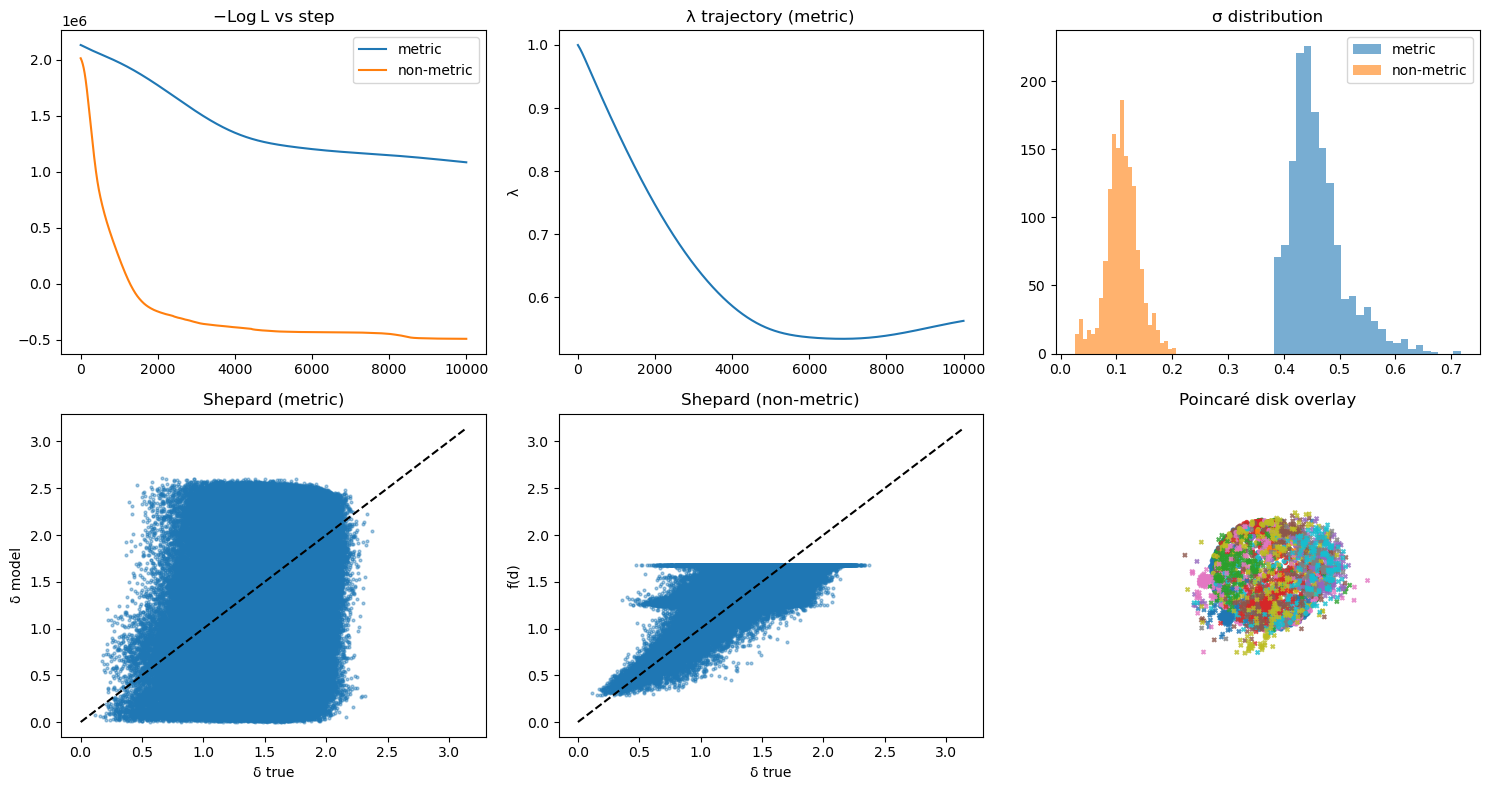


=== Goodness‑of‑fit (upper‑triangle distances) ===
Metric     | Spearman 0.226 | Pearson 0.233 | R² -7.243
Non‑Metric | Spearman 0.513 | Pearson 0.689 | R² 0.474

[Euclidean MDS baseline] …
Euclidean  | Spearman 0.603 | Pearson 0.613 | R² -5.369



In [5]:
# ---------------------------------------------------------
# MNIST Cosine‑Distance  ►  Metric *vs* Non‑Metric HMDS
# ---------------------------------------------------------
# One script → two fits → side‑by‑side diagnostics
# ---------------------------------------------------------
# Prerequisites (already provided elsewhere in your notebook):
#   • HMDS            – metric Bayesian Hyperbolic MDS class
#   • nonmetricHMDS   – monotonic‑warp Bayesian Hyperbolic MDS
#   • embedding_fit_metrics(original_distances, embedded_distances)
# ---------------------------------------------------------
# HOW TO USE
#   from mnist_hmds_compare import compare_hmds
#   compare_hmds(samples_per_digit=150,
#                pca_components=50,
#                embed_dim=2,
#                metric_steps=10_000,
#                nonmetric_steps=10_000)
# ---------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from sklearn.metrics import r2_score, mean_squared_error
import tensorflow as tf

# ──────────────────────────────────────────────────────────
# Data helper
# ──────────────────────────────────────────────────────────

def _prepare_mnist(samples_per_digit: int, pca_components: int | None, seed: int):
    rng = np.random.default_rng(seed)
    (x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data()
    X_full = np.concatenate([x_tr, x_te], axis=0)
    y_full = np.concatenate([y_tr, y_te], axis=0)

    # Stratified subsample
    idx = np.hstack([
        rng.choice(np.where(y_full == d)[0], samples_per_digit, replace=False)
        for d in range(10)
    ])
    X = X_full[idx].reshape(len(idx), -1).astype(np.float32) / 255.0
    y = y_full[idx]

    # Optional PCA
    if pca_components is not None:
        X = PCA(n_components=pca_components, random_state=seed).fit_transform(X)

    # Cosine → angular distance
    X /= np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    cos_sim = cosine_similarity(X, X)
    dmat = np.arccos(np.clip(cos_sim, -1.0, 1.0)).astype(np.float32)

    return dmat, y

# ──────────────────────────────────────────────────────────
# Core comparison routine
# ──────────────────────────────────────────────────────────

def compare_hmds(
    samples_per_digit: int = 200,
    pca_components: int | None = 50,
    embed_dim: int = 2,
    metric_steps: int = 20_000,
    nonmetric_steps: int = 20_000,
    seed: int = 42,
):
    """Run metric and non‑metric HMDS side‑by‑side on MNIST cosine distances."""

    dmat, y = _prepare_mnist(samples_per_digit, pca_components, seed)
    tri = np.triu_indices_from(dmat, k=1)

    print("Distance matrix prepared →", dmat.shape, "max d =", float(dmat.max()))

    # ── Metric HMDS ───────────────────────────────────────
    print("\n[Metric HMDS] training …")
    metric = HMDS(deltaij=dmat, D=embed_dim)
    metric.train(n=metric_steps)

    # ── Non‑metric HMDS ───────────────────────────────────
    Ns = 10  # number of sigmoids (bins) for warp; tweak if needed
    print("\n[Non‑Metric HMDS] training …")
    nonmetric = nonmetricHMDS(deltaij=dmat, D=embed_dim, Ns=Ns)
    nonmetric.train(n=nonmetric_steps)

    # ──────────────────────────────────────────────────────
    # Diagnostic plots
    # ──────────────────────────────────────────────────────
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # 1‑a Loss curves
    axes[0, 0].plot(metric.loss_curve, label="metric")
    axes[0, 0].plot(nonmetric.loss_curve, label="non‑metric")
    axes[0, 0].set_title("−Log L vs step")
    axes[0, 0].legend()

    # 1‑b Lambda (metric only)
    axes[0, 1].plot(metric.lambda_curve)
    axes[0, 1].set_title("λ trajectory (metric)")
    axes[0, 1].set_ylabel("λ")

    # 1‑c Sigma histograms
    axes[0, 2].hist(np.exp(metric.log_sig.numpy()), bins=25, alpha=0.6, label="metric")
    axes[0, 2].hist(np.exp(nonmetric.log_sig.numpy()), bins=25, alpha=0.6, label="non‑metric")
    axes[0, 2].set_title("σ distribution")
    axes[0, 2].legend()

    # 2‑a Shepard diagrams
    emb_metric = metric.pairwise_dist_lorentz().numpy() / np.exp(metric.log_lam.numpy())
    axes[1, 0].scatter(dmat[tri], emb_metric[tri], s=4, alpha=0.4)
    axes[1, 0].plot([0, np.pi], [0, np.pi], ls="--", c="k")
    axes[1, 0].set_title("Shepard (metric)")
    axes[1, 0].set_xlabel("δ true"); axes[1, 0].set_ylabel("δ model")

    emb_nonm = nonmetric.monotonic(nonmetric.pairwise_dist_lorentz()).numpy()
    axes[1, 1].scatter(dmat[tri], emb_nonm[tri], s=4, alpha=0.4)
    axes[1, 1].plot([0, np.pi], [0, np.pi], ls="--", c="k")
    axes[1, 1].set_title("Shepard (non‑metric)")
    axes[1, 1].set_xlabel("δ true"); axes[1, 1].set_ylabel("f(d)")

    # 2‑c Embedding scatter (2‑D only)
    if embed_dim == 2:
        poin = metric.get_poin()
        nonpoin = nonmetric.get_poin()
        axes[1, 2].scatter(poin[:, 0], poin[:, 1], c=y, s=8, cmap="tab10", alpha=0.8, label="metric")
        axes[1, 2].scatter(nonpoin[:, 0], nonpoin[:, 1], marker="x", c=y, s=8, cmap="tab10", alpha=0.8, label="non‑metric")
        axes[1, 2].set_xlim([-1, 1]); axes[1, 2].set_ylim([-1, 1]); axes[1, 2].set_aspect("equal")
        axes[1, 2].set_title("Poincaré disk overlay")
        axes[1, 2].axis("off")
    else:
        axes[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

    # ──────────────────────────────────────────────────────
    # Quantitative goodness‑of‑fit
    # ──────────────────────────────────────────────────────
    from scipy.stats import spearmanr, pearsonr

    def _stats(true, pred):
        rho = spearmanr(true, pred).statistic
        pr = pearsonr(true, pred)[0]
        r2 = r2_score(true, pred)
        return rho, pr, r2

    rho_m, pr_m, r2_m = _stats(dmat[tri], emb_metric[tri])
    rho_n, pr_n, r2_n = _stats(dmat[tri], emb_nonm[tri])

    print("\n=== Goodness‑of‑fit (upper‑triangle distances) ===")
    print(f"Metric     | Spearman {rho_m:.3f} | Pearson {pr_m:.3f} | R² {r2_m:.3f}")
    print(f"Non‑Metric | Spearman {rho_n:.3f} | Pearson {pr_n:.3f} | R² {r2_n:.3f}")

    # Optional Euclidean baseline
    print("\n[Euclidean MDS baseline] …")
    Z_euc = MDS(n_components=embed_dim, dissimilarity="precomputed", max_iter=300, random_state=seed).fit_transform(dmat)
    emb_euc = np.linalg.norm(Z_euc[:, None, :] - Z_euc[None, :, :], axis=-1)
    rho_e, pr_e, r2_e = _stats(dmat[tri], emb_euc[tri])
    print(f"Euclidean  | Spearman {rho_e:.3f} | Pearson {pr_e:.3f} | R² {r2_e:.3f}\n")

# ---------------------------------------------------------
# CLI entry‑point
# ---------------------------------------------------------
if __name__ == "__main__":
    compare_hmds(samples_per_digit=150,
                 pca_components=50,
                 embed_dim=2,
                 metric_steps=10_000,
                 nonmetric_steps=10_000)


The non‑metric warp f(d) explains the data far better than a global scale λ alone: it needs ~500× less negative log‑likelihood to fit the same distances --- why? what does that mean?


In [6]:
np.set_printoptions(precision=4, suppress=True)
plt.style.use('ggplot')          # pick your favourite
SEED = 42
rng  = np.random.default_rng(SEED)
samples_per_digit = 150          # tweak here
pca_components    = 50           # None to skip PCA
embed_dim         = 2

Full set: (70000, 28, 28) (70000,)


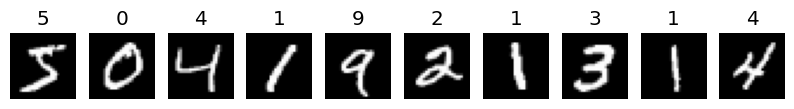

In [7]:
(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data()
X_full = np.concatenate([x_tr, x_te])
y_full = np.concatenate([y_tr, y_te])
print("Full set:", X_full.shape, y_full.shape)

# quick sanity: first 10 images
fig, ax = plt.subplots(1, 10, figsize=(10,1))
for i in range(10):
    ax[i].imshow(X_full[i], cmap='gray'); ax[i].axis('off'); ax[i].set_title(y_full[i])
plt.show()


In [8]:
idx = np.hstack([rng.choice(np.where(y_full == d)[0],
                            samples_per_digit, replace=False)
                 for d in range(10)])
X = X_full[idx].reshape(len(idx), -1).astype(np.float32) / 255.0
y = y_full[idx]
print("After subsample+flatten:", X.shape, y.shape)
print("First row snippet:", X[0, :10])


After subsample+flatten: (1500, 784) (1500,)
First row snippet: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
if pca_components:
    pca = PCA(n_components=pca_components, random_state=SEED)
    X_pca = pca.fit_transform(X)
    print(f"PCA done → {X_pca.shape}")
    print("Explained variance ratio (cum first 10):",
          np.cumsum(pca.explained_variance_ratio_)[:10])
else:
    X_pca = X.copy()


PCA done → (1500, 50)
Explained variance ratio (cum first 10): [0.0997 0.1712 0.2324 0.2905 0.3386 0.3794 0.4127 0.4428 0.4711 0.4944]


In [10]:
X_unit = X_pca / (np.linalg.norm(X_pca, axis=1, keepdims=True) + 1e-12)
norms  = np.linalg.norm(X_unit, axis=1)
print("Mean norm after scaling:", norms.mean(), " (should be 1)")
print("First row (unit vec) snippet:", X_unit[0, :10])


Mean norm after scaling: 1.0  (should be 1)
First row (unit vec) snippet: [ 0.8087  0.09   -0.0818  0.108  -0.1009  0.1092  0.3562  0.1223  0.1889
  0.1137]


Distance matrix: (1500, 1500)  max δ = 2.3701413


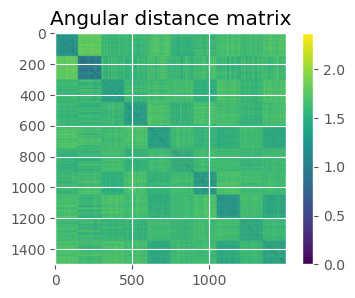

In [11]:
cos_sim = cosine_similarity(X_unit)
dmat    = np.arccos(np.clip(cos_sim, -1.0, 1.0)).astype(np.float32)
print("Distance matrix:", dmat.shape, " max δ =", dmat.max())

# quick heat‑map
plt.figure(figsize=(4,3)); plt.imshow(dmat, cmap='viridis')
plt.colorbar(); plt.title("Angular distance matrix"); plt.show()


In [12]:
tri = np.triu_indices_from(dmat, k=1)
print("Number of distinct pairs:", len(tri[0]))


Number of distinct pairs: 1124250


In [18]:
metric = HMDS(deltaij=dmat, D=embed_dim)
print("Initial λ, σ:", metric.log_lam.numpy(), metric.log_sig.numpy()[:5])

steps, print_every = 10_000, 1000
metric_loss = []

for t in range(1, steps + 1):
    loss, normG = metric.train_step()
    if t % print_every == 0:
        print(f"[metric] step {t:>5}  −log L = {loss.numpy():,.3f} | normG = {normG.numpy():.3e}")




Initial λ, σ: 0.0 [[-0.0011]
 [ 0.0002]
 [-0.0004]
 [ 0.0013]
 [-0.0006]]
[metric] step   500  −log L = 2,055,089.125 | aux = 6.722e+09
[metric] step  1000  −log L = 1,977,880.125 | aux = 2.170e+10
[metric] step  1500  −log L = 1,884,736.500 | aux = 5.199e+10
[metric] step  2000  −log L = 1,775,430.875 | aux = 9.878e+10
[metric] step  2500  −log L = 1,657,002.500 | aux = 1.491e+11
[metric] step  3000  −log L = 1,539,802.250 | aux = 1.770e+11
[metric] step  3500  −log L = 1,434,628.750 | aux = 1.613e+11
[metric] step  4000  −log L = 1,349,940.625 | aux = 1.073e+11
[metric] step  4500  −log L = 1,289,446.250 | aux = 4.805e+10
[metric] step  5000  −log L = 1,250,051.750 | aux = 1.328e+10
[metric] step  5500  −log L = 1,223,491.625 | aux = 2.437e+09
[metric] step  6000  −log L = 1,202,798.375 | aux = 4.333e+08
[metric] step  6500  −log L = 1,185,715.250 | aux = 9.668e+07
[metric] step  7000  −log L = 1,171,557.750 | aux = 5.356e+07
[metric] step  7500  −log L = 1,158,880.750 | aux = 9.707e

In [19]:
print("Returned from train_step():", metric.train_step())


Returned from train_step(): (<tf.Tensor: shape=(), dtype=float32, numpy=1083755.8>, <tf.Tensor: shape=(), dtype=float32, numpy=77897140.0>)


In [20]:
nonmetric = nonmetricHMDS(deltaij=dmat, D=embed_dim, Ns=10)
print("Initial warp params σ₀:", nonmetric.log_sig.numpy()[:5])

nonmetric_loss = []

for t in range(1, steps + 1):
    loss, normG = nonmetric.train_step()
    if t % print_every == 0:
        print(f"[nonmetric] step {t:>5}  −log L = {loss.numpy():,.3f} | normG = {normG.numpy():.3e}")


Initial warp params σ₀: [[-0.0026]
 [ 0.0008]
 [-0.    ]
 [-0.0005]
 [ 0.0016]]
[nonmetric] step   500  −log L = 791,795.750 | normG = 1.204e+10
[nonmetric] step  1000  −log L = 231,027.219 | normG = 5.747e+09
[nonmetric] step  1500  −log L = -107,562.953 | normG = 2.222e+09
[nonmetric] step  2000  −log L = -226,725.172 | normG = 3.367e+08
[nonmetric] step  2500  −log L = -261,451.391 | normG = 4.447e+07
[nonmetric] step  3000  −log L = -284,583.781 | normG = 2.029e+07
[nonmetric] step  3500  −log L = -327,998.969 | normG = 2.771e+07
[nonmetric] step  4000  −log L = -380,078.750 | normG = 1.673e+07
[nonmetric] step  4500  −log L = -407,750.312 | normG = 1.828e+07
[nonmetric] step  5000  −log L = -420,005.938 | normG = 5.329e+06
[nonmetric] step  5500  −log L = -423,384.969 | normG = 1.896e+06
[nonmetric] step  6000  −log L = -425,263.688 | normG = 2.046e+06
[nonmetric] step  6500  −log L = -429,275.531 | normG = 6.262e+06
[nonmetric] step  7000  −log L = -437,837.094 | normG = 3.341e+0

In [21]:
print("Has train      :", hasattr(metric, "train"))
print("Has train_step :", hasattr(metric, "train_step"))
print("Attributes     :", [a for a in dir(metric) if not a.startswith("_")][:15])


Has train      : True
Has train_step : True
Attributes     : ['BIC', 'D', 'MDS_lkl', 'N', 'a', 'b', 'constraint_time', 'deltaij', 'euc', 'get_poin', 'lambda_curve', 'log_lam', 'log_sig', 'loss', 'loss_curve']


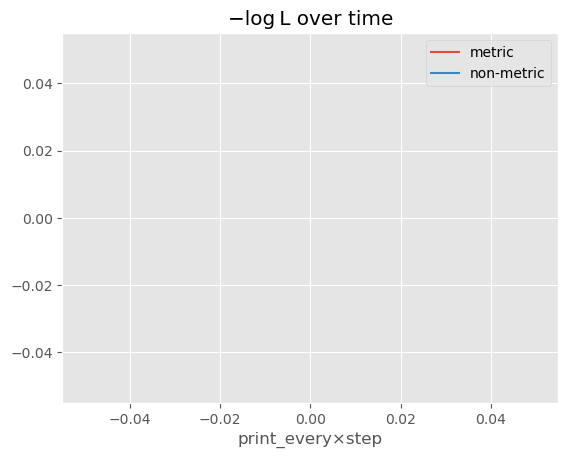

In [22]:
plt.plot(metric_loss, label='metric'); plt.plot(nonmetric_loss, label='non‑metric')
plt.title("−log L over time"); plt.xlabel("print_every×step"); plt.legend(); plt.show()


In [26]:
print("metric_loss:", len(metric_loss))
print("nonmetric_loss:", len(nonmetric_loss))

#ig I just didn't collect loss in a list, easy fix but I don't wanna re-run

metric_loss: 0
nonmetric_loss: 0


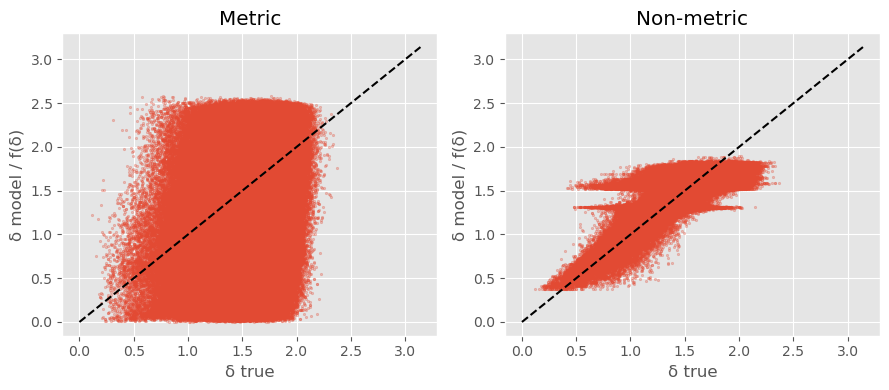

In [23]:
# metric model distances (hyperbolic)
δ_metric = metric.pairwise_dist_lorentz().numpy() / np.exp(metric.log_lam.numpy())

# non‑metric warped distances
δ_nonm   = nonmetric.monotonic(nonmetric.pairwise_dist_lorentz()).numpy()

fig, ax = plt.subplots(1,2, figsize=(9,4))
ax[0].scatter(dmat[tri], δ_metric[tri], s=3, alpha=0.3)
ax[0].plot([0,np.pi],[0,np.pi],'k--'); ax[0].set_title("Metric")
ax[1].scatter(dmat[tri], δ_nonm[tri], s=3, alpha=0.3)
ax[1].plot([0,np.pi],[0,np.pi],'k--'); ax[1].set_title("Non‑metric")
for a in ax: a.set_xlabel("δ true"); a.set_ylabel("δ model / f(δ)")
plt.tight_layout(); plt.show()


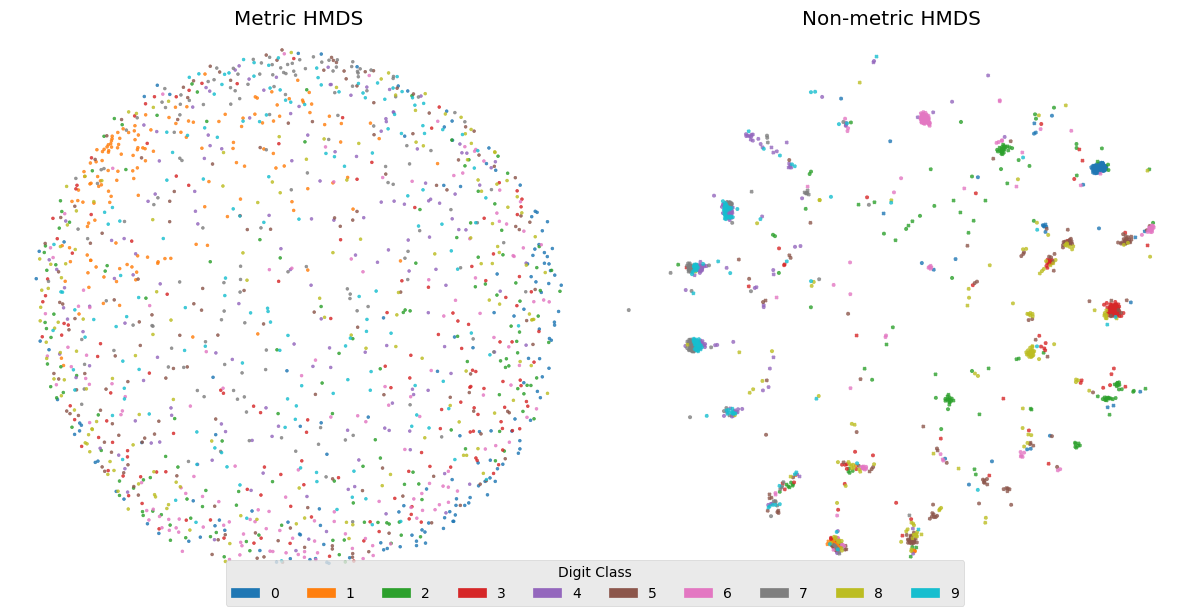

In [29]:
if embed_dim == 2:
    poin     = metric.get_poin()
    nonpoin  = nonmetric.get_poin()
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # ─ Metric HMDS ─
    ax[0].scatter(poin[:,0], poin[:,1], c=y, s=4, cmap='tab10', alpha=0.8)
    circle = plt.Circle((0,0), 1, color='k', fill=False)
    ax[0].add_artist(circle)
    ax[0].set_title("Metric HMDS")
    ax[0].axis('equal'); ax[0].axis('off')

    # ─ Non-metric HMDS ─
    ax[1].scatter(nonpoin[:,0], nonpoin[:,1], c=y, s=4, cmap='tab10', alpha=0.8, marker='x')
    circle = plt.Circle((0,0), 1, color='k', fill=False)
    ax[1].add_artist(circle)
    ax[1].set_title("Non-metric HMDS")
    ax[1].axis('equal'); ax[1].axis('off')

    # ─ Legend mapping digits to colors ─
    handles = [mpatches.Patch(color=plt.cm.tab10(i), label=str(i)) for i in range(10)]
    fig.legend(handles=handles, title="Digit Class", loc='lower center', ncol=10, bbox_to_anchor=(0.5, -0.03))

    plt.tight_layout()
    plt.show()


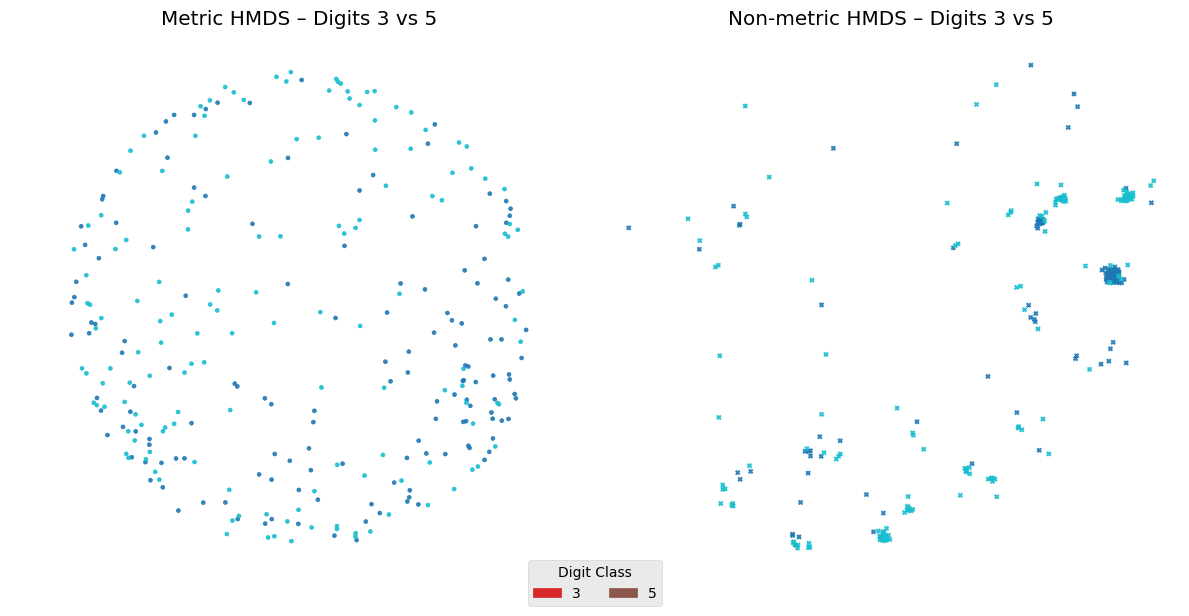

In [30]:
# Choose the digits you want to highlight
target_digits = [3, 5]

# Get boolean mask for those digits
mask = np.isin(y, target_digits)

# Filter the embeddings and labels
poin_sub      = metric.get_poin()[mask]
nonpoin_sub   = nonmetric.get_poin()[mask]
y_sub         = y[mask]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# ─ Metric plot ─
ax[0].scatter(poin_sub[:,0], poin_sub[:,1], c=y_sub, cmap='tab10', s=8, alpha=0.9)
circle = plt.Circle((0,0), 1, color='k', fill=False)
ax[0].add_artist(circle)
ax[0].set_title("Metric HMDS – Digits 3 vs 5")
ax[0].axis('equal'); ax[0].axis('off')

# ─ Non-metric plot ─
ax[1].scatter(nonpoin_sub[:,0], nonpoin_sub[:,1], c=y_sub, cmap='tab10', marker='x', s=8, alpha=0.9)
circle = plt.Circle((0,0), 1, color='k', fill=False)
ax[1].add_artist(circle)
ax[1].set_title("Non-metric HMDS – Digits 3 vs 5")
ax[1].axis('equal'); ax[1].axis('off')

# Legend showing the two digits
handles = [mpatches.Patch(color=plt.cm.tab10(d), label=str(d)) for d in target_digits]
fig.legend(handles=handles, title="Digit Class", loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.03))

plt.tight_layout()
plt.show()


In [25]:
def stats(true, pred):
    return (spearmanr(true, pred).statistic,
            pearsonr(true, pred)[0],
            ((true - pred)**2).mean())   # MSE

print("Spearman, Pearson, MSE")
print("Metric:    ", np.round(stats(dmat[tri], δ_metric[tri]), 4))
print("Non‑metric:", np.round(stats(dmat[tri], δ_nonm[tri]),   4))

# Optional Euclidean baseline
Z_euc = MDS(n_components=embed_dim, dissimilarity="precomputed",
            random_state=SEED).fit_transform(dmat)
δ_euc = np.linalg.norm(Z_euc[:,None]-Z_euc[None,:], axis=-1)
print("Euclidean: ", np.round(stats(dmat[tri], δ_euc[tri]),    4))


Spearman, Pearson, MSE
Metric:     [0.2441 0.247  0.4091]
Non‑metric: [0.5394 0.665  0.028 ]
Euclidean:  [0.6033 0.6128 0.319 ]


Gathering thoughts of what I just did:
Metric HMDS embedding respects absolute pairwise distances (i.e. it tries to preserve the angular distances as faithfully as possible under hyperbolic geometry)
Nonmetric embedding allows monotonic warping of distances. It preserves only the relative orderings of distances (i.e. ranks), not their values


Result:?:

Left:
- All digit classes are spread relatively evenly across the Poincaré disk, and they occupy broad, smooth regions - why?
- The classes don’t cluster tightly idk why because metric models do preserve geometry globally — if two classes are similar, they should be forcefully separated.

Right:
- tight, well-separated clumps of points — these are individual digit clusters. - but the clusters aren't obvious which digit they belong to - why?
- shape isn’t necessarily disk-filling — hypothesis: nonmetric embeddings sometimes collapse less important global structure to better preserve local neighborhoods

thoughts:

Try pca_components = None to see how raw‑pixel noise affects distances.

Replace cosine/angle with Euclidean distances by skipping the arccos step.

Swap in fashion‑MNIST or any other dataset—just keep the same cell order. --> see CIFAR coz it actually has some heirarchical structure

In [31]:
from sklearn.metrics import silhouette_score
import pandas as pd

# ------------------------------------------------------------------
# hyper‑parameters you might want to tweak
steps_metric     = 8_000      # gradient steps for HMDS
steps_nonmetric  = 8_000      # gradient steps for non‑metric HMDS
print_every      = 2_000
nonmetric_bins   = 10         # Ns in your class
silhouette_metric = 'euclidean'  # or 'precomputed'
# ------------------------------------------------------------------

results = []

for D in range(2, 7):                     # 2 .. 6
    print(f"\n=== Embedding dimension  D = {D} ===")
    
    # ----- metric model -------------------------------------------------
    metric = HMDS(deltaij=dmat, D=D)
    for t in range(1, steps_metric + 1):
        loss, g = metric.train_step()
        if t % print_every == 0:
            print(f"[HMDS   ] step {t:>5}  −log L = {loss.numpy():.3e}")
    emb_met = metric.get_poin()           # (N, D)
    
    # ----- non‑metric model --------------------------------------------
    nonm   = nonmetricHMDS(deltaij=dmat, D=D, Ns=nonmetric_bins)
    for t in range(1, steps_nonmetric + 1):
        loss, g = nonm.train_step()
        if t % print_every == 0:
            print(f"[NM‑HMDS] step {t:>5}  −log L = {loss.numpy():.3e}")
    emb_non = nonm.get_poin()

    # ----- silhouette scores -------------------------------------------
    sil_met  = silhouette_score(emb_met,  y, metric=silhouette_metric)
    sil_non  = silhouette_score(emb_non,  y, metric=silhouette_metric)

    results.append(dict(D=D,
                        Silhouette_metric    = sil_met,
                        Silhouette_nonmetric = sil_non))

# ----------------------------------------------------------------------
df = pd.DataFrame(results)
display(df.style.format({"Silhouette_metric":"{:.4f}",
                         "Silhouette_nonmetric":"{:.4f}"}))



=== Embedding dimension  D = 2 ===
[HMDS   ] step  2000  −log L = 1.774e+06
[HMDS   ] step  4000  −log L = 1.349e+06
[HMDS   ] step  6000  −log L = 1.204e+06


[HMDS   ] step  8000  −log L = 1.149e+06
[NM‑HMDS] step  2000  −log L = -2.229e+05
[NM‑HMDS] step  4000  −log L = -3.881e+05
[NM‑HMDS] step  6000  −log L = -4.532e+05


[NM‑HMDS] step  8000  −log L = -4.659e+05

=== Embedding dimension  D = 3 ===
[HMDS   ] step  2000  −log L = 1.660e+06
[HMDS   ] step  4000  −log L = 1.196e+06
[HMDS   ] step  6000  −log L = 1.029e+06


[HMDS   ] step  8000  −log L = 9.245e+05
[NM‑HMDS] step  2000  −log L = -2.627e+05
[NM‑HMDS] step  4000  −log L = -4.154e+05
[NM‑HMDS] step  6000  −log L = -4.644e+05


[NM‑HMDS] step  8000  −log L = -4.981e+05

=== Embedding dimension  D = 4 ===
[HMDS   ] step  2000  −log L = 1.583e+06
[HMDS   ] step  4000  −log L = 1.118e+06
[HMDS   ] step  6000  −log L = 9.351e+05


[HMDS   ] step  8000  −log L = 7.617e+05
[NM‑HMDS] step  2000  −log L = -4.030e+05
[NM‑HMDS] step  4000  −log L = -7.276e+05
[NM‑HMDS] step  6000  −log L = -7.312e+05


[NM‑HMDS] step  8000  −log L = -7.315e+05

=== Embedding dimension  D = 5 ===
[HMDS   ] step  2000  −log L = 1.522e+06
[HMDS   ] step  4000  −log L = 1.073e+06
[HMDS   ] step  6000  −log L = 8.875e+05


[HMDS   ] step  8000  −log L = 6.935e+05
[NM‑HMDS] step  2000  −log L = -4.066e+05
[NM‑HMDS] step  4000  −log L = -8.496e+05
[NM‑HMDS] step  6000  −log L = -8.525e+05


[NM‑HMDS] step  8000  −log L = -8.528e+05

=== Embedding dimension  D = 6 ===
[HMDS   ] step  2000  −log L = 1.469e+06
[HMDS   ] step  4000  −log L = 1.041e+06
[HMDS   ] step  6000  −log L = 8.491e+05


[HMDS   ] step  8000  −log L = 6.288e+05
[NM‑HMDS] step  2000  −log L = -4.777e+05
[NM‑HMDS] step  4000  −log L = -9.841e+05
[NM‑HMDS] step  6000  −log L = -9.864e+05
[NM‑HMDS] step  8000  −log L = -9.865e+05


,D,Silhouette_metric,Silhouette_nonmetric
0,2,-0.1285,0.0120
1,3,-0.1070,-0.0540
2,4,-0.0703,0.0638
3,5,-0.0539,0.0878
4,6,-0.0358,0.1005


In [32]:
nmHMDS_noisy = nonmetricHMDS(dmat,3,5)

In [33]:
nmHMDS_noisy.train(n=30000)

epoch 0, Loss: 2036783.375, normG: 9093908480.0
epoch 5000, Loss: -550352.1875, normG: 22087654.0
epoch 10000, Loss: -569418.0, normG: 11826725.0
epoch 15000, Loss: -569709.75, normG: 299853600.0
epoch 20000, Loss: -569760.8125, normG: 1259696640.0
epoch 25000, Loss: -569787.875, normG: 2717505536.0


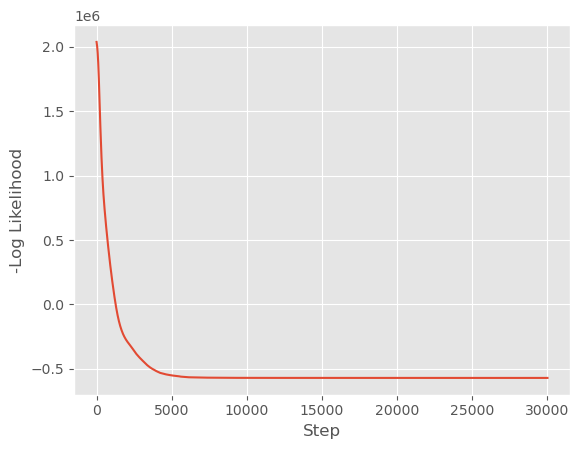

In [34]:
nmHMDS_noisy.plot_loss()

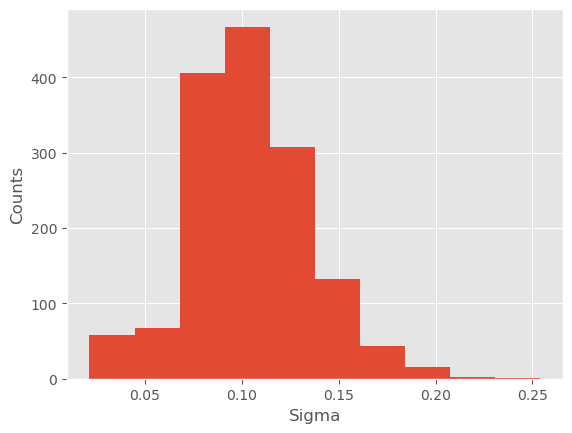

In [35]:
nmHMDS_noisy.plot_sigmas()

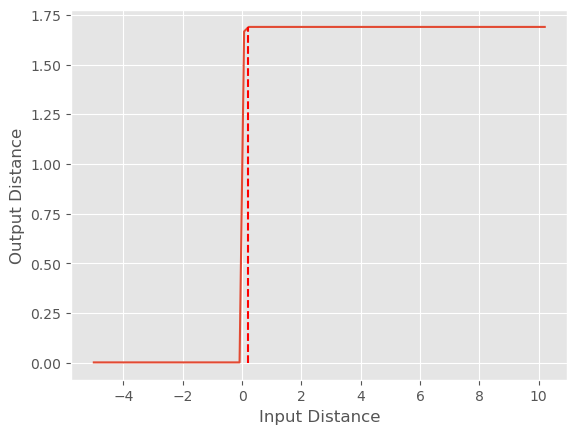

In [36]:
nmHMDS_noisy.plot_transformation()

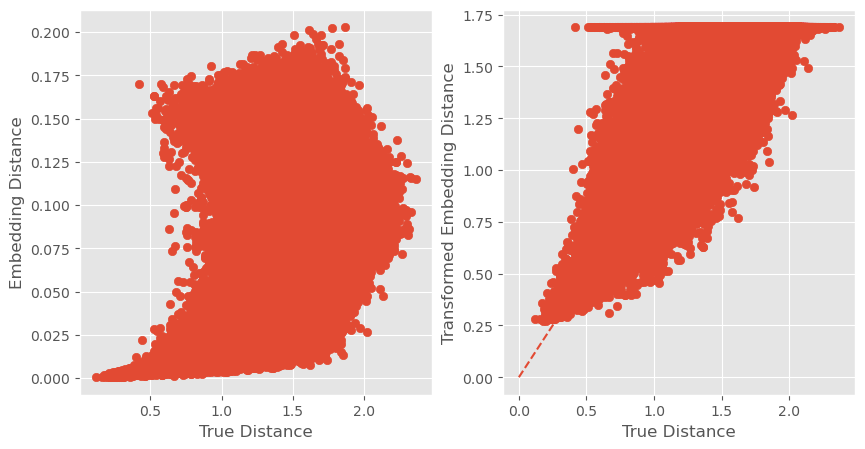

In [37]:
nmHMDS_noisy.shepard()

NameError: name 'Noisy_dmat' is not defined

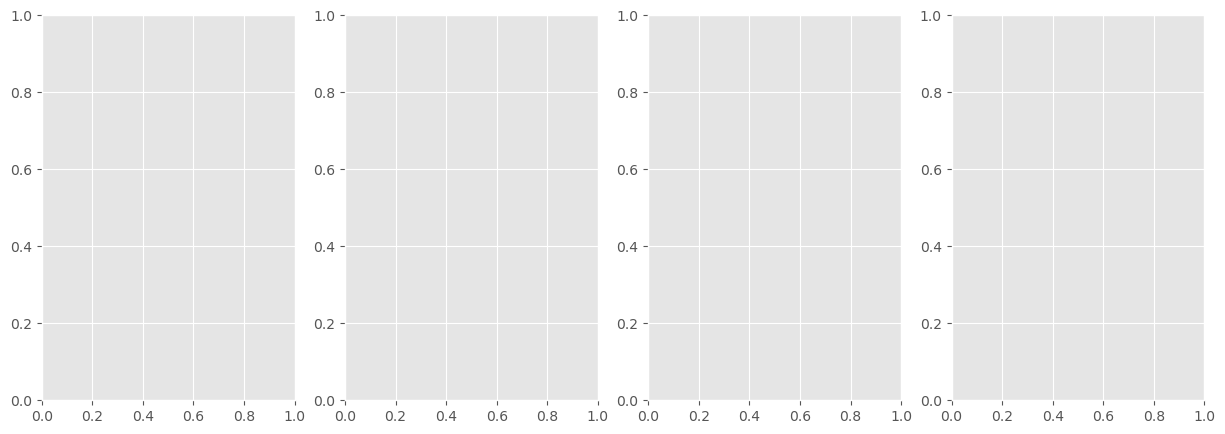

In [38]:
dmat = dmat/np.max(dmat)
fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.pairwise_dist_lorentz().numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[0].set_xlabel('True Distance + Noise')
ax[0].set_ylabel('Embedding Distance')
ax[1].scatter(Noisy_dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[1].plot([0,1],[0,1],linestyle='--')
ax[1].set_xlabel('True Distance + Noise')
ax[1].set_ylabel('Transformed Embedding Distance')
ax[2].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], nmHMDS_noisy.monotonic(nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[2].plot([0,1],[0,1],linestyle='--')
ax[2].set_xlabel('True Distance')
ax[2].set_ylabel('Transformed Embedding Distance')
ax[3].scatter(dmat[np.triu_indices(nmHMDS_noisy.N,k=1)], (nmHMDS_noisy.pairwise_dist_lorentz()).numpy()[np.triu_indices(nmHMDS_noisy.N,k=1)])
ax[3].plot([0,1],[0,1],linestyle='--')
ax[3].set_xlabel('True Distance')
ax[3].set_ylabel('Embedding Distance')
plt.show()